In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image, ImageFile

import torch
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch import nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

In [2]:
from data.ent import ENTDataset

In [3]:
from tensorboardX import SummaryWriter

In [4]:
writer = SummaryWriter('/data/pytorch_workspace/logs/')

data_name = 'ent'
data_dir = '/data/entsurgery/data/'
train_data= os.path.join(data_dir,'mastoidectomay_data_train.csv')
val_data= os.path.join(data_dir,'mastoidectomay_data_val.csv')

img_dir = os.path.join(data_dir, 'images')
img_path_train= os.path.join(img_dir, 'train/')
img_path_val= os.path.join(img_dir, 'val/')

In [5]:
img_size = 256
batch_size = 8
model_name = 'vgg16_bn'

In [6]:
transformations = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
    )])

train_dataset = ENTDataset(train_data, img_path_train, transformations)
val_dataset = ENTDataset(val_data, img_path_val, transformations)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
if model_name == 'simplecnn':
    model = SimpleNet()
elif model_name == 'vgg16_bn':
    model = models.vgg16_bn(pretrained=True)
    #num_ftrs = model.classifier[6].in_features
    #features = list(model.classifier.children())[:-1]
    #features.extend([nn.Linear(num_ftrs, 2)])
    #model.classifier = nn.Sequential(*features)
    features = list(model.features.children())[:-1]
    features.extend([nn.Conv2d(features[40].out_channels, 1024, 
                                   kernel_size=(3,3), 
                                   padding=(1, 1))])
    features.extend([nn.UpsamplingBilinear2d(scale_factor=16)])
    features.extend([nn.ReLU(True)])
    features.extend([nn.AvgPool2d(kernel_size=(14, 14))])
    model.features = nn.Sequential(*features)
    


if torch.cuda.is_available():
    #torch.set_default_tensor_type('torch.cuda.FloatTensor')
    model = model.cuda() # On GPU
# freeze all model parameters for pretrained model
#if model_name is not 'simplecnn':
#    for param in model.parameters():
#        param.requires_grad = False
torch.backends.cudnn.benchmark = True
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = F.binary_cross_entropy_with_logits
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

data_loaders = {'train':train_loader, 'valid':val_loader}

In [10]:
# train by epoch
def train(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': dataloders['train'].__len__(), 
                     'valid': dataloders['valid'].__len__()}
    iterations = 0
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloders[phase]:
                iterations += 1
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda(async=True)), Variable(labels.cuda(async=True))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
               
                optimizer.zero_grad()
                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs.data, 1)
                _, targets = torch.max(labels.data, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == targets).float() / batch_size

            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()
                best_iters = iterations
        
        writer.add_scalars('Loss', {'training': train_epoch_loss, 'validation': valid_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'training': train_epoch_acc, 'validation': valid_epoch_acc}, epoch)
                
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
                  'valid loss: {:.4f} acc: {:.4f}'.format(
                    epoch, num_epochs - 1,
                    train_epoch_loss, train_epoch_acc, 
                    valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 
               os.path.join(os.getcwd(), 'models/{}_{}_{}.pth'.format(data_name, model_name, repr(best_iters))))
    #writer.close()
    return model

In [11]:
start_time = time.time()
model = train(data_loaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python2.7/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")



RuntimeError: CUDA error: out of memory

In [172]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

In [53]:

def visualize_model(data_loder, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(data_loder):
        if  torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda(async=True)), Variable(labels.cuda(async=True))
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, 'Prediction: {}/Answer: {}'.format(
                'Left' if preds[j] == 0 else 'Right', 
                'Left' if labels.data[:,1][j] == 0 else 'Right'),
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

In [54]:
#visualize_model(data_loaders['valid'], model)

In [55]:
test_data = os.path.join(data_dir, 'mastoidectomay_data_test.csv')
img_path_test=os.path.join(img_dir, 'test/')
test_dataset= ENTDataset(test_data, img_path_test, transformations)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [56]:
 # Load model from best iteration
model_path = './models/ent_vgg16_bn_79728.pth'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)

In [57]:
# train by epoch
def predict(test_loders, model, criterion, optimizer):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    dataset_size = test_loader.__len__()
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(test_loader):
        model.train(False)
        model.eval()
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(async=True)), Variable(labels.cuda(async=True))
        else:
            inputs, labels = Variable(inputs), Variable(labels)
     
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
        _, targets = torch.max(labels.data, 1)
        
        running_loss += loss.data[0]
        running_corrects += torch.sum(preds == targets).float()
        torch.cuda.empty_cache()
        
    test_loss = (running_loss / batch_size) / dataset_size 
    test_acc = (running_corrects / batch_size) / dataset_size        
    
    
    print('Test loss: {:4f} Test Acc: {:4f}'.format(test_loss, test_acc))
    
    return 

In [ ]:
predict(test_loader, model, criterion, optimizer)

In [58]:
import io, shutil
import cv2
import pdb

In [59]:
img_path = 'test.jpg'
img = Image.open(img_path)
img = img.convert('RGB')
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [60]:
tensor = preprocess(img)

In [61]:
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

In [62]:
model.cuda()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [63]:
from torch import topk

In [64]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
    def remove(self): 
        self.hook.remove()

In [65]:
final_layer = model._modules.get('features')

In [66]:
activated_features = SaveFeatures(final_layer)

In [ ]:
# we run the image through our model and get the prediction.
# then run that through a softmax(or sigmoid) layer 
# to turn that prediction into a series of probabilities for each of the 2 classes

In [67]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [68]:
topk(pred_probabilities,1)

(tensor([0.7171], device='cuda:0'), tensor([0], device='cuda:0'))

In [119]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [120]:
weight_softmax_params = list(model._modules.get('classifier').parameters())
weight_softmax = np.squeeze(weight_softmax_params[4].cpu().data.numpy())

In [121]:
class_idx = topk(pred_probabilities,1)[1].int()

In [122]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

ValueError: shapes (4096,) and (512,49) not aligned: 4096 (dim 0) != 512 (dim 0)

In [84]:
from matplotlib.pyplot import imshow
import skimage.transform

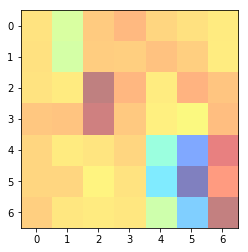

In [85]:
imshow(overlay[0], alpha=0.5, cmap='jet')

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


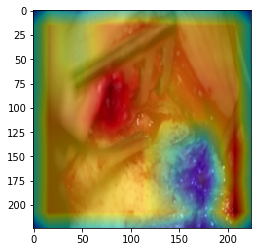

In [86]:
imshow(display_transform(img))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');